House Prices Distribution

In [39]:
#libraries to be used

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error #for evaluation
from sklearn.pipeline import make_pipeline #for pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #for training and test splitting
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder #for binary items preparation
from sklearn.linear_model import LogisticRegression, LinearRegression#for modeling

LOADING AND CLEANING

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
#look for any outliers
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Based on the summary above, you can see that there is a high jump from then 75 percentile to maximum price.

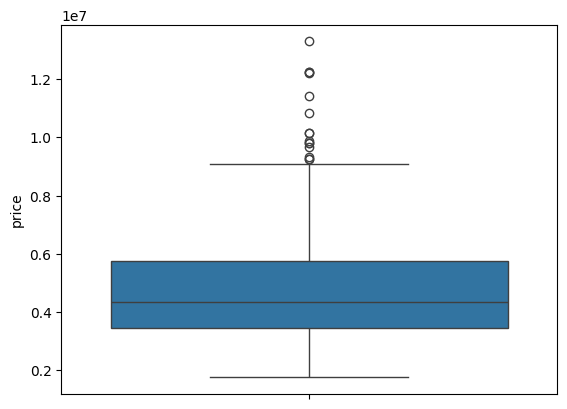

In [5]:
sns.boxplot(df['price']);

As you can see we have a high outlier of 10e7 which corresponds to 10 Million

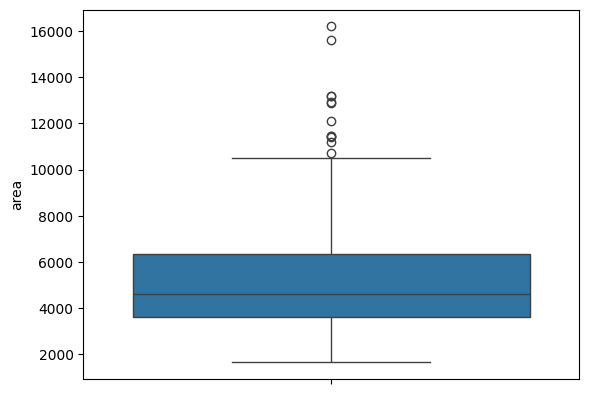

In [6]:
sns.boxplot(df['area']);

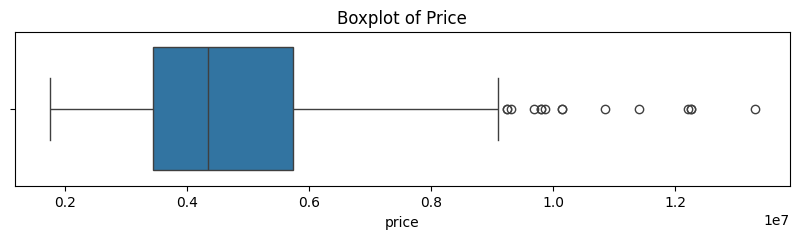

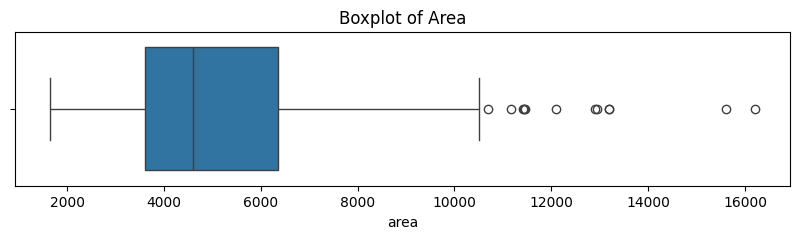

In [7]:
# Boxplot for price
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['price'])
plt.title("Boxplot of Price")
plt.show()

# Boxplot for area
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['area'])
plt.title("Boxplot of Area")
plt.show()

In [8]:
print("Skewness of Price:", df['price'].skew())
print("Skewness of Area:", df['area'].skew())

Skewness of Price: 1.2122388370279802
Skewness of Area: 1.321188343153483


In [9]:
def wrangle(filepath):
  #read csv file
  df = pd.read_csv(filepath)

  #delete duplicates
  df.drop_duplicates(inplace = True)

  # remove outliers for price and area
  df = df[df['price'] < 1e7]
  df = df[df['area'] < 11000]


  return df


In [10]:
df = wrangle("/content/drive/MyDrive/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished
11,9681000,6000,4,3,2,yes,yes,yes,yes,no,2,no,semi-furnished
12,9310000,6550,4,2,2,yes,no,no,no,yes,1,yes,semi-furnished
13,9240000,3500,4,2,2,yes,no,no,yes,no,2,no,furnished


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527 entries, 8 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             527 non-null    int64 
 1   area              527 non-null    int64 
 2   bedrooms          527 non-null    int64 
 3   bathrooms         527 non-null    int64 
 4   stories           527 non-null    int64 
 5   mainroad          527 non-null    object
 6   guestroom         527 non-null    object
 7   basement          527 non-null    object
 8   hotwaterheating   527 non-null    object
 9   airconditioning   527 non-null    object
 10  parking           527 non-null    int64 
 11  prefarea          527 non-null    object
 12  furnishingstatus  527 non-null    object
dtypes: int64(6), object(7)
memory usage: 57.6+ KB


Furnished and unfurnished with corresponding rooms, later prices

In [12]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.270000e+02,527.000000,527.000000,527.000000,527.000000,527.000000
mean,4.633972e+06,4948.929791,2.950664,1.271347,1.798861,0.662239
std,1.668570e+06,1842.232514,0.733134,0.474036,0.864025,0.843087
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3520.000000,2.000000,1.000000,1.000000,0.000000
50%,4.270000e+06,4500.000000,3.000000,1.000000,2.000000,0.000000
75%,5.600000e+06,6100.000000,3.000000,2.000000,2.000000,1.000000
max,9.870000e+06,10700.000000,6.000000,3.000000,4.000000,3.000000


Something is strange with the parking data, we are about find out.

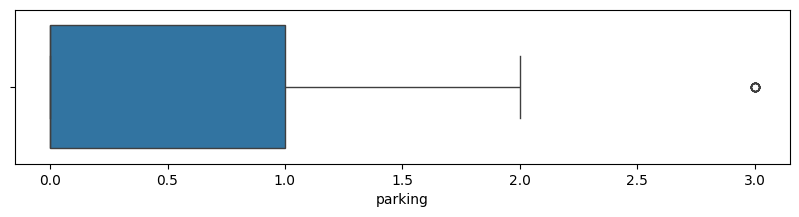

In [13]:
plt.figure(figsize=(10, 2))
sns.boxplot(x = df['parking']);

based on the boxplot it's so weird.

In [14]:
df['parking'].value_counts()

,count
parking,
0,296
1,123
2,98
3,10


Got it! Seems like there are many houses with no parking lots, 296 to be precise.

In [15]:
parking_lots = df.groupby('furnishingstatus').parking.value_counts().unstack().fillna(0).astype(int)
parking_lots

parking,0,1,2,3
furnishingstatus,,,,
furnished,59,39,29,3
semi-furnished,121,49,46,5
unfurnished,116,35,23,2


<Figure size 1000x200 with 0 Axes>

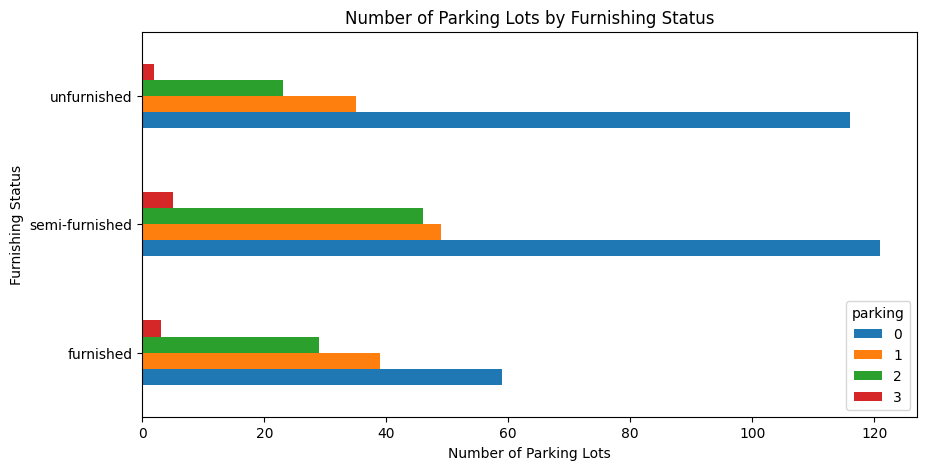

In [16]:
plt.figure(figsize=(10, 2))
parking_lots.plot(kind = "barh", figsize = (10,5))
plt.xlabel("Number of Parking Lots")
plt.title('Number of Parking Lots by Furnishing Status')
plt.ylabel('Furnishing Status')
plt.show()

In [17]:
furnished_df = df.groupby('furnishingstatus')['bedrooms'].value_counts().unstack().fillna(0).astype(int)
furnished_df

bedrooms,1,2,3,4,5,6
furnishingstatus,,,,,,
furnished,1,27,73,24,4,1
semi-furnished,0,50,123,46,2,0
unfurnished,1,57,96,18,3,1


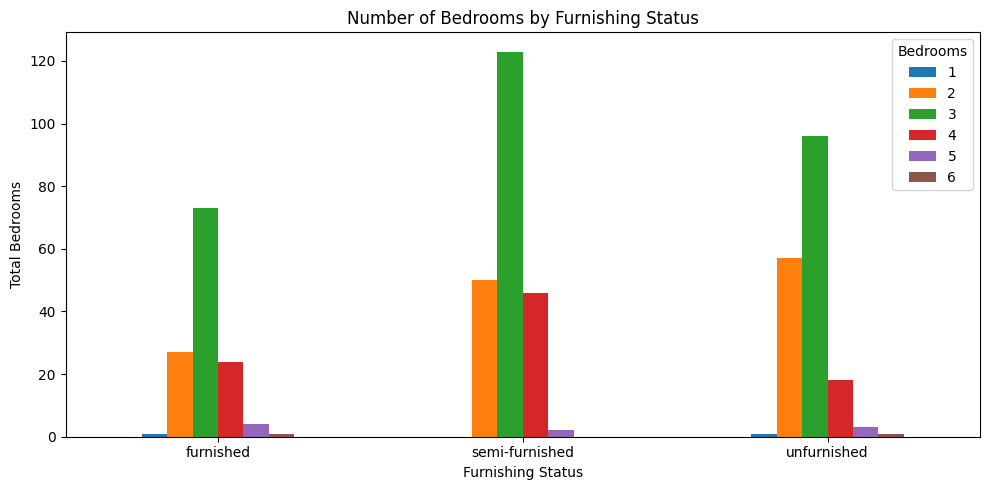

In [18]:
furnished_df.plot(kind= "bar", figsize = (10,5))
plt.xlabel("Furnishing Status")

plt.title('Number of Bedrooms by Furnishing Status')
plt.xlabel('Furnishing Status')
plt.ylabel('Total Bedrooms')
plt.legend(title='Bedrooms')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As displayed on the grouped bar chart, you can see that the houses with 3 bedrooms are the most in our dataset.

In [19]:
most_expensive = df.groupby('furnishingstatus')['price'].mean().sort_values(ascending = True)
most_expensive

,price
furnishingstatus,
unfurnished,3.981886e+06
semi-furnished,4.803615e+06
furnished,5.228403e+06


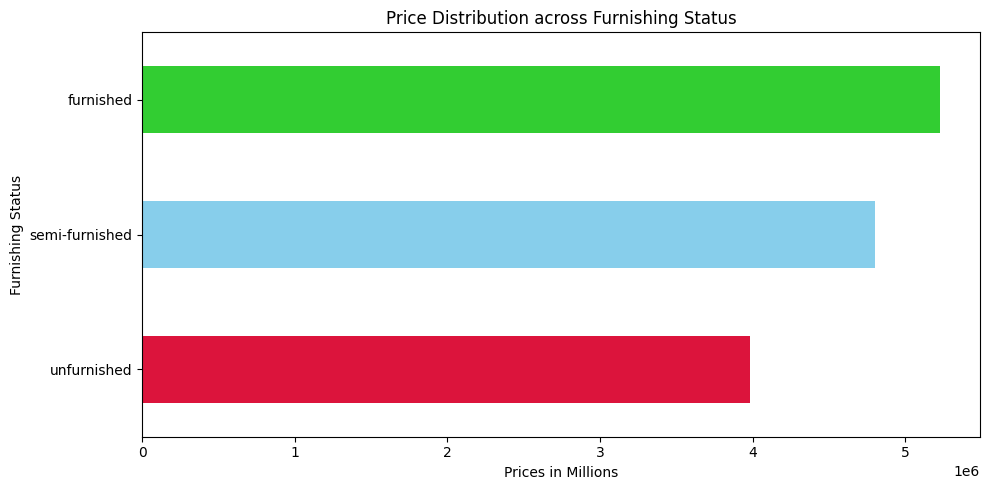

In [20]:
color_map = ['crimson','skyblue', 'limegreen']
most_expensive.plot(kind = "barh", figsize = (10,5), color = color_map)

plt.title('Price Distribution across Furnishing Status')
plt.ylabel('Furnishing Status')
plt.xlabel('Prices in Millions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The average price for furnished houses are above 5Million which concludes it to be the most expensive houses and obviously unfurnished are the cheapest.

In [21]:
price_stats = df.groupby(['furnishingstatus', 'bedrooms'])['price'].mean().unstack().fillna(0).astype(int)
price_stats

bedrooms,1,2,3,4,5,6
furnishingstatus,,,,,,
furnished,3150000,3987925,5386252,6070458,5974500,6083000
semi-furnished,0,3984260,4923532,5404380,4095000,0
unfurnished,2275000,3070666,4452838,4254250,5320000,3500000


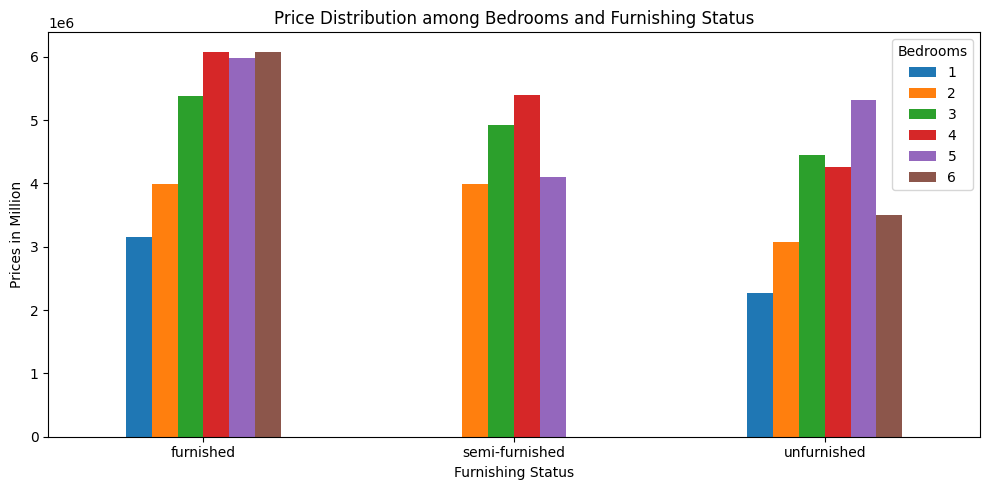

In [22]:
price_stats.plot(kind= "bar", figsize = (10,5))

plt.title('Price Distribution among Bedrooms and Furnishing Status')
plt.xlabel('Furnishing Status')
plt.ylabel('Prices in Million')
plt.legend(title='Bedrooms')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

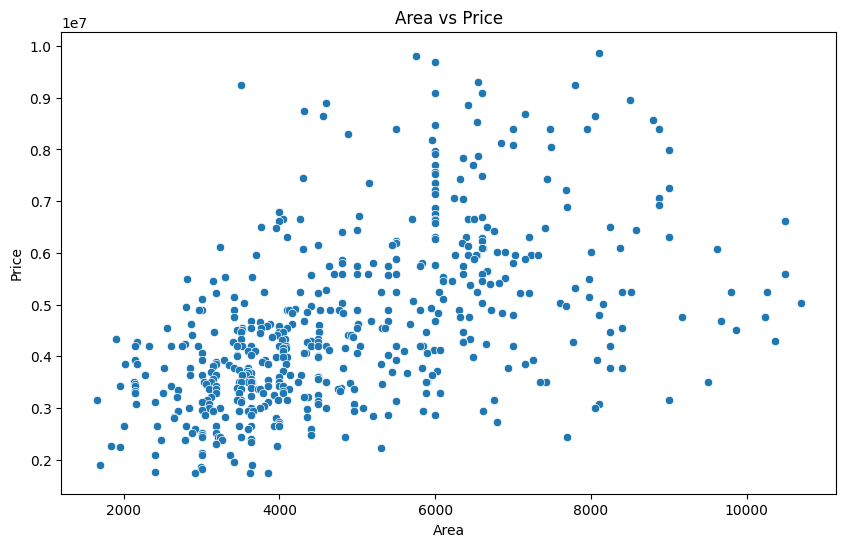

In [23]:
plt.figure(figsize =(10, 6))
sns.scatterplot(x = "area", y = "price", data = df)
plt.title("Area vs Price")
plt.xlabel("Area")
plt.ylabel("Price")
plt.show()

In [24]:
df[['area', 'price']].corr()

,area,price
area,1.000000,0.523592
price,0.523592,1.000000


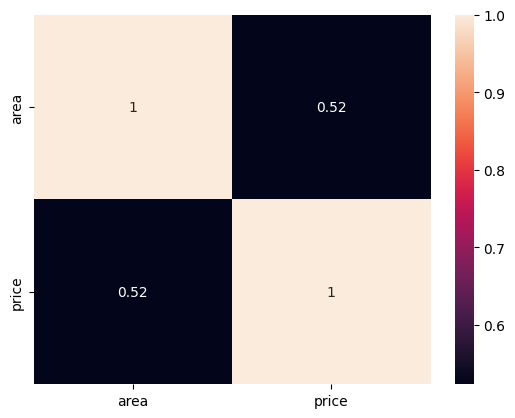

In [25]:
sns.heatmap(df[['area', 'price']].corr(), annot = True);

The relationship between Area and Price is non-linear.

PREPROCESSING

In [26]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [27]:
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished
11,9681000,6000,4,3,2,yes,yes,yes,yes,no,2,no,semi-furnished
12,9310000,6550,4,2,2,yes,no,no,no,yes,1,yes,semi-furnished
13,9240000,3500,4,2,2,yes,no,no,yes,no,2,no,furnished


Encoding Phase

In [47]:
# Binary categorical columns
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Encode Yes/No columns using OneHotEncoder
oht = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = oht.fit_transform(df[binary_cols]).astype(int)


encoded_df = pd.DataFrame(encoded_array, columns=oht.get_feature_names_out(binary_cols), index=df.index)

# Add encoded columns to df and drop original binary columns
df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=binary_cols, inplace=True)

# Encode furnishingstatus using LabelEncoder
le = LabelEncoder()
df['furnishingstatus_encoded'] = le.fit_transform(df['furnishingstatus']).astype(int)

# drop the original furnishingstatus
df.drop(columns=['furnishingstatus'], inplace=True)


In [29]:
df.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_encoded
8,9870000,8100,4,1,2,2,1,1,1,0,1,1,0
9,9800000,5750,3,2,4,1,1,1,0,0,1,1,2
11,9681000,6000,4,3,2,2,1,1,1,1,0,0,1
12,9310000,6550,4,2,2,1,1,0,0,0,1,1,1
13,9240000,3500,4,2,2,2,1,0,0,1,0,0,0


After turning yes and no into 1 and 0 respectively.

In [30]:
rename_columns = {
    'furnishingstatus_encoded': 'furnishingstatus',
    'mainroad_yes': 'mainroad',
    'guestroom_yes': 'guestroom',
    'basement_yes': 'basement',
    'hotwaterheating_yes': 'hotwaterheating',
    'airconditioning_yes': 'airconditioning',
    'prefarea_yes': 'prefarea'
}

df.rename(columns=rename_columns, inplace=True)

I feel like I need to rename the columns for better interpreting.

In [31]:
df.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
8,9870000,8100,4,1,2,2,1,1,1,0,1,1,0
9,9800000,5750,3,2,4,1,1,1,0,0,1,1,2
11,9681000,6000,4,3,2,2,1,1,1,1,0,0,1
12,9310000,6550,4,2,2,1,1,0,0,0,1,1,1
13,9240000,3500,4,2,2,2,1,0,0,1,0,0,0


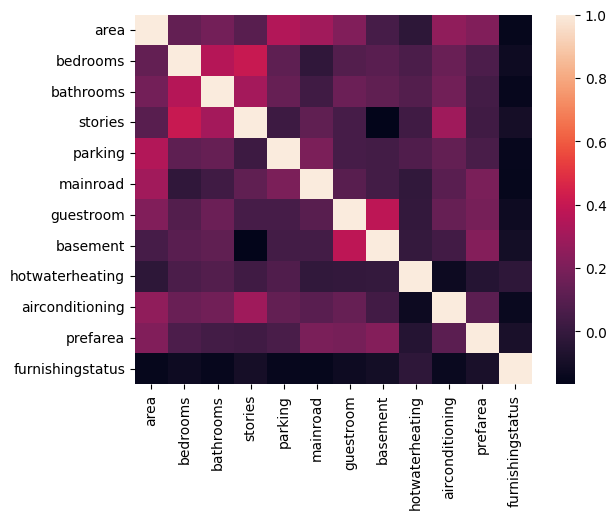

In [32]:
correlation = df.drop(columns = 'price').corr()
sns.heatmap(correlation); # include annot=True if you want to easliy see the correlation

No issue of multicollinearity.

**Train and Test Splitting**

In [33]:
# Split data
X = df.drop(columns='price')  # features
y = df['price']               # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train Model

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predicting

In [48]:
y_pred = model.predict(X_test)
y_pred_baseline = [y_train.mean()] * len(y_test)
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_baseline))

Baseline MAE: 1545628.2158383008


The baseline to beat

In [49]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Absolute Error: 890377.0483258264
Mean Squared Error: 1499115139258.8425
R-squared: 0.5998955029295183


Interept Coefficients

In [41]:
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: 516980.7576502897
Coefficients: [ 2.09591822e+02  1.08023724e+05  8.73056059e+05  4.40028480e+05
  1.46597707e+05  4.47883134e+05  3.67096494e+05  2.25041182e+05
  8.87098844e+05  7.71374298e+05  6.60415439e+05 -2.01492135e+05]


Map Coefficients

In [42]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})
print(coef_df)

             Feature    Coefficient
0               area     209.591822
1           bedrooms  108023.724051
2          bathrooms  873056.058618
3            stories  440028.479873
4            parking  146597.706639
5           mainroad  447883.134352
6          guestroom  367096.493859
7           basement  225041.181732
8    hotwaterheating  887098.844179
9    airconditioning  771374.297730
10          prefarea  660415.438761
11  furnishingstatus -201492.134669


Vsualize to chech residuals

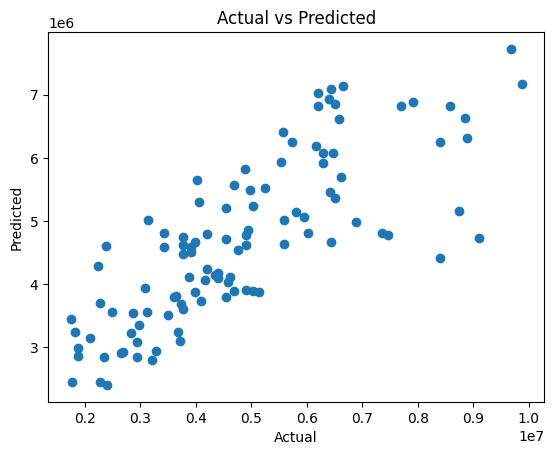

In [43]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

Plot residuals

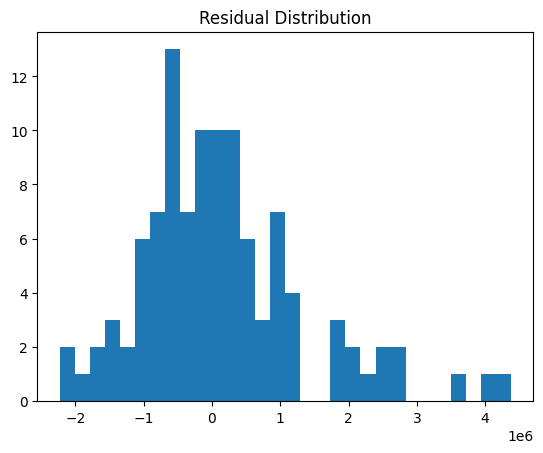

In [44]:
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()

In [50]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({
    "Index": range(len(y_test)),
    "Actual": y_test.values,
    "Predicted": y_pred
})

# Melt the DataFrame to long format for lineplot
melted_df = results_df.melt(id_vars="Index", value_vars=["Actual", "Predicted"],
                            var_name="Type", value_name="Value")

fig = px.line(melted_df, x="Index", y="Value", color="Type",
              title="Actual vs Predicted Line Plot")
fig.show()